In [ ]:
import pandas as pd
from src.utils.path_utils import get_raw_data_dir

In [3]:
import glob

# List all csv files
csv_files = glob.glob(str(get_raw_data_dir()) + "/Dataset_O1/**/*.csv", recursive=True)

dfs = []
for file in csv_files:
    df = pd.read_csv(file, header=None, names=['time', 'measurement', 'label'])
    df['source'] = file  # Track file origin
    dfs.append(df)

raw_data = pd.concat(dfs, ignore_index=True)
raw_data = raw_data.sort_values(['source', 'time']).reset_index(drop=True)

In [14]:
len(csv_files)

44

In [4]:
raw_data

,time,measurement,label,source
0,0.0000,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
1,0.0002,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
2,0.0004,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
3,0.0006,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
4,0.0008,1.610419,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
...,...,...,...,...
7479995,33.9990,1.639846,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
7479996,33.9992,1.639846,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
7479997,33.9994,1.639846,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
7479998,33.9996,1.639846,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...


# Plotting

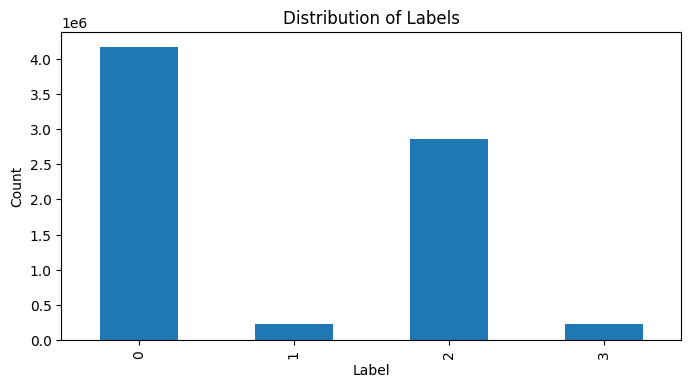

In [5]:
import matplotlib.pyplot as plt

label_counts = raw_data['label'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

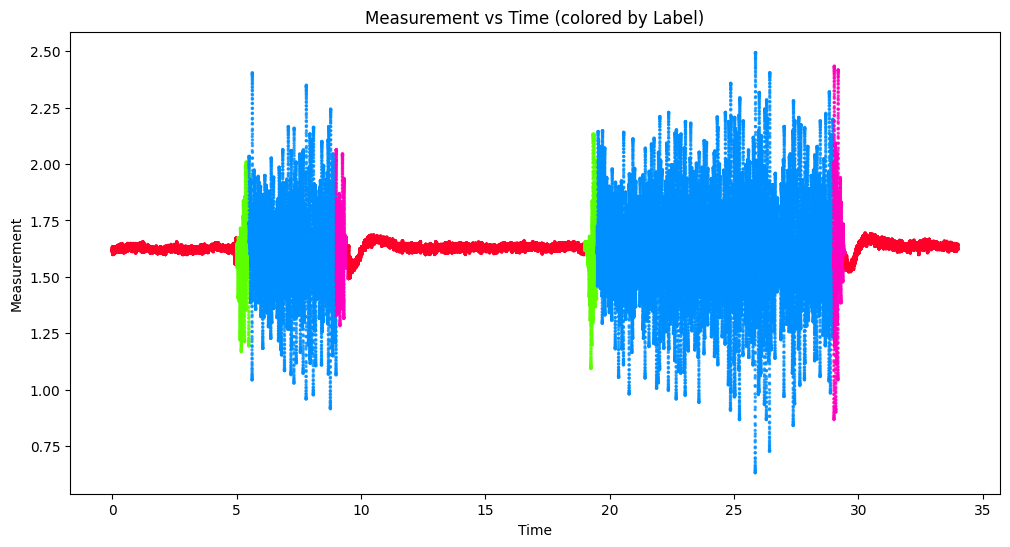

In [11]:
# Select a single file's data
single_file = raw_data[raw_data['source'] == csv_files[0]]

plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    single_file['time'],
    single_file['measurement'],
    c=single_file['label'],
    cmap='gist_rainbow',
    s=2,
    alpha=0.7
)
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Measurement vs Time (colored by Label)')
plt.show()

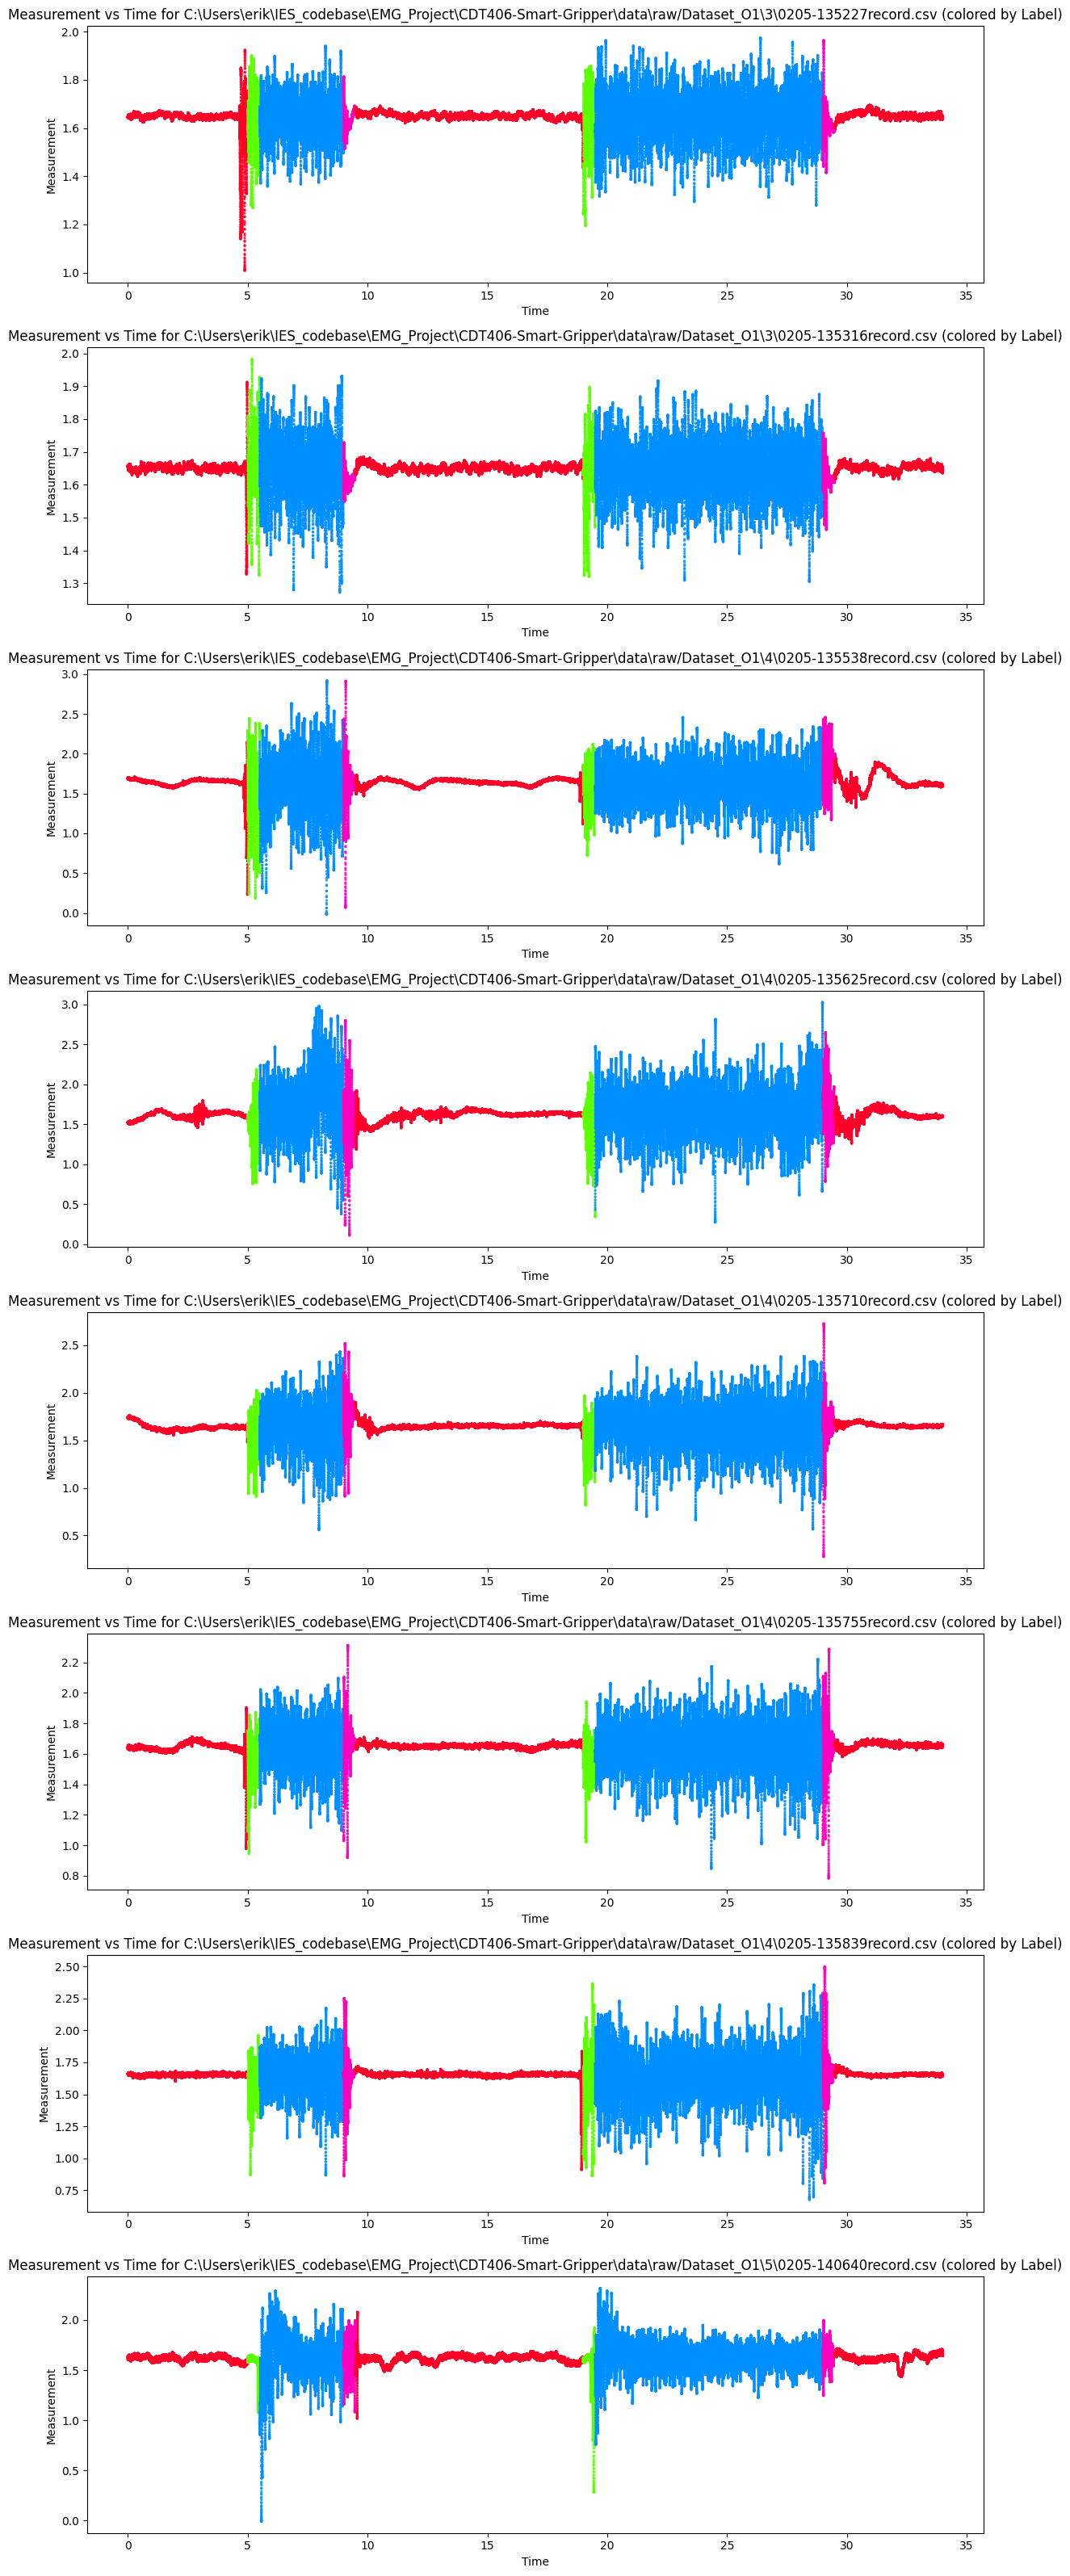

In [9]:
import matplotlib.pyplot as plt

start_idx = 12  # inclusive, 0-based index
end_idx = 20    # exclusive

files_to_plot = csv_files[start_idx:end_idx]
num_files = len(files_to_plot)
fig, axes = plt.subplots(num_files, 1, figsize=(12, 4 * num_files), sharex=False)

if num_files == 1:
    axes = [axes]  # Ensure axes is iterable

for idx, file in enumerate(files_to_plot):
    file_data = raw_data[raw_data['source'] == file]
    ax = axes[idx]
    scatter = ax.scatter(
        file_data['time'],
        file_data['measurement'],
        c=file_data['label'],
        cmap='gist_rainbow',
        s=2,
        alpha=0.7
    )
    ax.set_title(f'Measurement vs Time for {file} (colored by Label)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Measurement')

plt.tight_layout()
plt.show()

# Outlier Detection
Sources:
- https://s-ai-f.github.io/Time-Series/outlier-detection-in-time-series.html
- https://medium.com/@alex.eslava96/outlier-detection-techniques-for-time-series-9868db2875c2


# Data Cleaning

In [23]:
def plot_file_by_index(raw_data, index):
    """
    Plots the data for the file at the given 1-based index in the [source] column.
    """
    unique_files = raw_data['source'].unique()
    if index < 1 or index > len(unique_files):
        raise ValueError(f"Index must be between 1 and {len(unique_files)}")
    file_to_plot = unique_files[index - 1]
    file_data = raw_data[raw_data['source'] == file_to_plot]

    plt.figure(figsize=(12, 6))
    plt.scatter(
        file_data['time'],
        file_data['measurement'],
        c=file_data['label'],
        cmap='gist_rainbow',
        s=2,
        alpha=0.7
    )
    plt.xlabel('Time')
    plt.ylabel('Measurement')
    plt.title(f'Measurement vs Time for file #{index} ({file_to_plot})')
    plt.show()

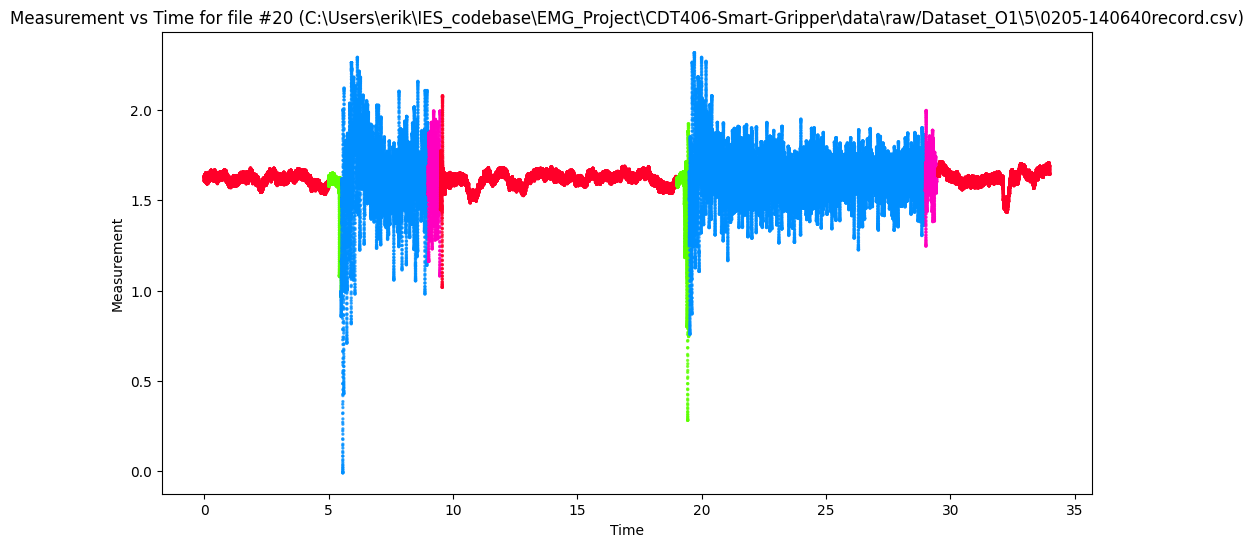

In [24]:
plot_file_by_index(raw_data, 20)

In [39]:
def get_data_by_index(raw_data, index):
    unique_files = raw_data['source'].unique()
    if index < 1 or index > len(unique_files):
        raise ValueError(f"Index must be between 1 and {len(unique_files)}")
    file_to_plot = unique_files[index - 1]
    file_data = raw_data[raw_data['source'] == file_to_plot]

    return file_data

In [72]:
data = get_data_by_index(raw_data, 10)

In [73]:
import numpy as np

def find_label_change_indices(labels, label_col='label'):
    """
    Returns the indices where the label changes in the sequence.
    For example, for [0,0,1,1,2,2,0,0,1,1,2,2,0], returns the indices where each segment ends.
    """
    labels = df[label_col].values
    change_points = np.where(labels[:-1] != labels[1:])[0]
    change_points = np.append(change_points, len(labels) - 1)
    return change_points.tolist()

In [74]:
def label_segment_occurrences_dict(data, change_indices, label_col='label'):
    """
    Returns a dict: {label: [occurrence indices]} for each label.
    """
    occurrences = {}
    result = {}
    for idx in change_indices:
        label = data.iloc[idx][label_col]
        count = occurrences.get(label, 0) + 1
        occurrences[label] = count
        if label not in result:
            result[label] = []
        result[label].append(count)
    return result

In [75]:
indices = find_label_change_indices(data)

In [76]:
indices

[24999, 27500, 45000, 47500, 95000, 97500, 144999, 147499, 169999]

In [70]:
result = label_segment_occurrences_dict(data, indices)

In [71]:
result

{np.int64(0): [1, 2, 3, 4],
 np.int64(1): [1, 2],
 np.int64(3): [1, 2],
 np.int64(2): [1]}